In [1]:
# ===== multimodal MELD training + conformal fusion =====
import os, gc, warnings, math, random
from dataclasses import dataclass
from typing import Dict, List, Tuple
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import chi2

import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import functional as TF

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
warnings.filterwarnings('ignore')

# -------------------- CONFIGURE YOUR DATA PATH --------------------
data_root = "/depot/gupta869/data/farbod/preprocessed_data"  # <--- change if needed

# -------------------- Utils --------------------
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# ==================== MODELS ====================
class ImprovedAudioModel(nn.Module):
    def __init__(self, num_classes=7, hidden_dim=512, dropout=0.4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Dropout2d(0.3)
        )
        self.fc1 = nn.Linear(512, hidden_dim); self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim); self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2); self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    def forward(self, audio_mel, **kwargs):
        x = self.conv1(audio_mel); x = self.conv2(x); x = self.conv3(x); x = self.conv4(x)
        x = x.view(x.size(0), -1)
        identity = x
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        if identity.size(1) == x.size(1):
            x = x + identity
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        return self.classifier(x)

class ImprovedVideoModel(nn.Module):
    def __init__(self, num_classes=7, hidden_dim=512, dropout=0.4):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        for p in resnet.parameters(): p.requires_grad = False
        for p in resnet.layer2.parameters(): p.requires_grad = True
        for p in resnet.layer3.parameters(): p.requires_grad = True
        for p in resnet.layer4.parameters(): p.requires_grad = True
        self.frozen_layers = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1)
        self.trainable_layers = nn.Sequential(resnet.layer2, resnet.layer3, resnet.layer4, resnet.avgpool)
        self.fc1 = nn.Linear(512, hidden_dim); self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim); self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2); self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    def forward(self, face, **kwargs):
        self.frozen_layers.eval()            # stable BN stats
        x = self.frozen_layers(face)         # no torch.no_grad() here
        x = self.trainable_layers(x)
        x = torch.flatten(x, 1)
        identity = x
        x1 = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x2 = self.dropout(F.relu(self.bn2(self.fc2(x1))))
        if identity.size(1) == x2.size(1): x2 = x2 + identity
        x3 = self.dropout(F.relu(self.bn3(self.fc3(x2))))
        return self.classifier(x3)

class ImprovedTextModel(nn.Module):
    def __init__(self, num_classes=7, hidden_dim=768, dropout=0.3):
        super().__init__()
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        for p in self.text_encoder.parameters(): p.requires_grad = False
        for p in self.text_encoder.encoder.layer[-8:].parameters(): p.requires_grad = True
        for p in self.text_encoder.pooler.parameters(): p.requires_grad = True
        text_dim = 768
        self.multihead_attn = nn.MultiheadAttention(text_dim, num_heads=4, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(text_dim, hidden_dim); self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim); self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2); self.ln3 = nn.LayerNorm(hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
    def forward(self, input_ids, attention_mask, **kwargs):
        out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        hs = out.last_hidden_state
        attn_output, _ = self.multihead_attn(hs, hs, hs, key_padding_mask=(attention_mask == 0))
        mask_expanded = attention_mask.unsqueeze(-1).expand(attn_output.size()).float()
        sum_embeddings = torch.sum(attn_output * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        feat = sum_embeddings / sum_mask
        x1 = self.dropout(F.gelu(self.ln1(self.fc1(feat))))
        x2 = self.dropout(F.gelu(self.ln2(self.fc2(x1))))
        x3 = self.dropout(F.gelu(self.ln3(self.fc3(x2 + x1))))
        return self.classifier(x3)

# ==================== Dataset ====================
class PreprocessedMELDDataset(Dataset):
    def __init__(self, data_dir, tokenizer, max_length=128, files=None, augment=False, target_audio_T=300):
        self.data_dir = data_dir; self.tokenizer = tokenizer; self.max_length = max_length
        self.augment = augment; self.target_audio_T = target_audio_T
        if files is None:
            assert data_dir is not None, "data_dir must be provided if files is None"
            self.files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')])
        else:
            self.files = files
        self.emotion_map = {'neutral':0,'joy':1,'surprise':2,'anger':3,'sadness':4,'disgust':5,'fear':6}
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        sample = torch.load(self.files[idx], map_location='cpu')

        # ----- text
        text = sample['utterance']
        enc = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        # ----- audio (1 x F x T) with padding-aware normalization
        audio_mel = sample['audio_mel']
        if isinstance(audio_mel, np.ndarray): audio_mel = torch.from_numpy(audio_mel)
        if audio_mel.dim() == 2: audio_mel = audio_mel.unsqueeze(0)
        T_target = self.target_audio_T
        T = audio_mel.shape[-1]
        if T < T_target:
            pad_val = float(audio_mel.min()); audio_mel = F.pad(audio_mel, (0, T_target - T), value=pad_val)
        elif T > T_target:
            audio_mel = audio_mel[:, :, :T_target]; T = T_target
        orig_T = min(T, T_target)
        pad_mask = torch.zeros(T_target, dtype=torch.bool); pad_mask[:orig_T] = True
        audio_lp = torch.log1p(audio_mel.clamp(min=0))
        valid = audio_lp[:, :, pad_mask]
        mean = valid.mean(); std = valid.std() + 1e-8
        audio_mel = (audio_lp - mean) / std
        audio_mel = torch.clamp(audio_mel, -3, 3)
        if self.augment:
            max_w = 20; w = np.random.randint(0, max_w+1); t0 = np.random.randint(0, max(1, T_target - w))
            audio_mel[:, :, t0:t0+w] = 0

        # ----- face -> 3x224x224 normalized
        face = torch.from_numpy(sample['face']).float()
        if face.ndim == 2: face = face.unsqueeze(-1).repeat(1,1,3)
        if face.shape[-1] == 4: face = face[..., :3]
        face = (face / 255.0).permute(2,0,1)
        face = TF.resize(face, [224,224], antialias=True)
        normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        face = normalize(face)

        # ----- label
        emo = sample['emotion']
        label = self.emotion_map.get(emo.lower(), 0) if isinstance(emo, str) else int(emo)

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'audio_mel': audio_mel[:, :, :T_target],
            'face': face,
            'label': label
        }

def collate_fn(batch, max_audio_length=300):
    input_ids = torch.stack([it['input_ids'] for it in batch])
    attention_mask = torch.stack([it['attention_mask'] for it in batch])
    labels = torch.tensor([it['label'] for it in batch])
    audio_mels = torch.stack([it['audio_mel'] for it in batch])
    faces = torch.stack([it['face'] for it in batch])
    return {'input_ids':input_ids,'attention_mask':attention_mask,'audio_mel':audio_mels,'face':faces,'label':labels}

# ==================== Train/Eval helpers ====================
def train_epoch(model, dataloader, optimizer, criterion, device, scheduler=None, grad_clip=5.0, view_name=""):
    model.train()
    total_loss = 0.0; all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc=f'Training {view_name}', leave=False)
    for batch_idx, batch in enumerate(pbar):
        ids = batch['input_ids'].to(device); mask = batch['attention_mask'].to(device)
        mel = batch['audio_mel'].to(device); face = batch['face'].to(device); y = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model(input_ids=ids, attention_mask=mask, audio_mel=mel, face=face)
        loss = criterion(logits, y)
        if torch.isnan(loss): 
            print(f"NaN loss @ batch {batch_idx}, skipping"); continue
        loss.backward()
        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        optimizer.step()
        if scheduler is not None: scheduler.step()
        total_loss += loss.item()
        preds = logits.argmax(1).detach().cpu().numpy()
        all_preds.extend(preds); all_labels.extend(y.detach().cpu().numpy())
        if batch_idx % 50 == 0:
            pbar.set_postfix({'loss': f'{loss.item():.3f}', 'grad': f'{float(total_norm):.2f}'})
    avg_loss = total_loss / max(1, len(dataloader))
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, acc, f1

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            ids = batch['input_ids'].to(device); mask = batch['attention_mask'].to(device)
            mel = batch['audio_mel'].to(device); face = batch['face'].to(device)
            y = batch['label'].cpu().numpy()
            logits = model(input_ids=ids, attention_mask=mask, audio_mel=mel, face=face)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds); all_labels.extend(y)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, f1

# ==================== Conformal & Fusion ====================
def compute_s(probs, y, score_type, params=None):
    if params is None: params = {}
    if score_type == 'hinge': return 1 - probs[y]
    if score_type == 'cross_entropy': return -np.log(probs[y] + 1e-12)
    if score_type == 'margin': return np.max(np.delete(probs, y)) - probs[y]
    if score_type == 'raps':
        u = params.get('u', 0.1); lam = params.get('lam', 0.01); k_reg = params.get('k_reg', 5)
        idx = np.argsort(-probs); ranks = np.empty(len(probs), int); ranks[idx] = np.arange(1, len(probs)+1)
        R_y = ranks[y]; cumsum = 0.0
        for r in range(1, R_y): cumsum += probs[idx[r-1]]
        return cumsum + u*probs[y] + lam*max(R_y - k_reg, 0)
    raise ValueError(f"Unknown score_type: {score_type}")

def compute_nonconformity_scores(model, loader, device, score_type='hinge', params=None):
    model.eval(); scores, labels = [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device); mask = batch['attention_mask'].to(device)
            mel = batch['audio_mel'].to(device); face = batch['face'].to(device)
            yb = batch['label'].cpu().numpy()
            probs = F.softmax(model(input_ids=ids, attention_mask=mask, audio_mel=mel, face=face), dim=1).cpu().numpy()
            for i in range(len(yb)): scores.append(compute_s(probs[i], yb[i], score_type, params))
            labels.extend(yb)
    return np.array(scores), np.array(labels)

def classwise_scores(scores, labels, L):
    out = {c: [] for c in range(L)}
    for s, y in zip(scores, labels): out[int(y)].append(float(s))
    return {c: np.asarray(v, float) for c, v in out.items()}

def per_view_pvalues_and_probs(model, class_scores, loader, L, device, score_type='hinge', params=None):
    model.eval(); probs_all = []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device); mask = batch['attention_mask'].to(device)
            mel = batch['audio_mel'].to(device); face = batch['face'].to(device)
            probs = F.softmax(model(input_ids=ids, attention_mask=mask, audio_mel=mel, face=face), dim=1).cpu().numpy()
            probs_all.append(probs)
            del ids, mask, mel, face
            if torch.cuda.is_available(): torch.cuda.empty_cache()
    probs_all = np.vstack(probs_all); n = probs_all.shape[0]; pvals = np.zeros((n, L))
    for i in range(n):
        for y in range(L):
            s_y = compute_s(probs_all[i], y, score_type, params)
            cal = class_scores.get(y, np.array([]))
            pvals[i, y] = 1.0 if cal.size == 0 else (1 + np.sum(cal >= s_y)) / (len(cal) + 1)
    return pvals, probs_all

def build_fusion_features(pvals_list, probs_list): return np.hstack([np.hstack([pvals_list[k], probs_list[k]]) for k in range(len(pvals_list))])
def min_p_value_fusion(P_all): K = P_all.shape[0]; return K * np.min(P_all, axis=0)
def fisher_fusion(P_all):
    eps = 1e-12; p = np.clip(P_all, eps, 1.0)
    T = -2 * np.sum(np.log(p), axis=0); df = 2 * P_all.shape[0]
    return 1 - chi2.cdf(T, df=df)
def adjusted_fisher_fusion(P_train, y_train, P_test, L):
    K, _, _ = P_train.shape; n_test = P_test.shape[1]; eps = 1e-12; out = np.zeros((n_test, L))
    for y in range(L):
        idx = np.where(y_train == y)[0]
        if idx.size < 5: out[:, y] = fisher_fusion(P_test)[:, y]; continue
        P_cls = np.clip(P_train[:, idx, y], eps, 1.0); W = -2 * np.log(P_cls)
        Wc = W - W.mean(axis=1, keepdims=True); Sigma = (Wc @ Wc.T) / max(W.shape[1] - 1, 1)
        var_T = np.sum(Sigma); 
        if not np.isfinite(var_T) or var_T <= 0: var_T = 4 * K
        f_y = (8.0 * K * K) / var_T; c_y = var_T / (4 * K)
        P_t = np.clip(P_test[:, :, y], eps, 1.0); T_t = -2 * np.sum(np.log(P_t), axis=0)
        out[:, y] = 1 - chi2.cdf(T_t / c_y, df=f_y)
    return out
def weighted_average_fusion(P_all, weights): return np.tensordot(weights, P_all, axes=(0, 0))
def learn_view_weights_from_pvals(pv_train_concat, y_train, K, L, max_iter, seed):
    lr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=max_iter, random_state=seed, class_weight='balanced')
    lr.fit(pv_train_concat, y_train); B = lr.coef_; imps = []
    for k in range(K): imps.append(np.linalg.norm(B[:, k*L:(k+1)*L], ord="fro"))
    w = np.maximum(np.array(imps, float), 1e-12); return w / w.sum()
def fused_class_cal_scores(y_cal, fused_probs_cal, L):
    s = 1 - fused_probs_cal[np.arange(len(y_cal)), y_cal]; out = {c: [] for c in range(L)}
    for sc, yy in zip(s, y_cal): out[int(yy)].append(float(sc))
    return {c: np.asarray(v, float) for c, v in out.items()}
def fused_p_values_from_cal(fused_probs, cal_class_scores):
    n, L = fused_probs.shape; out = np.zeros((n, L))
    for y in range(L):
        cal = cal_class_scores.get(y, np.array([]))
        if cal.size == 0: out[:, y] = 1.0
        else:
            s_test = 1 - fused_probs[:, y]
            counts = np.sum(cal[:, None] >= s_test[None, :], axis=0)
            out[:, y] = (1 + counts) / (len(cal) + 1)
    return out
def evaluate_sets(P, y_true, alpha):
    C = (P > alpha); cov = float(np.mean(C[np.arange(len(y_true)), y_true])); size = float(np.mean(C.sum(axis=1)))
    return cov, size

# ==================== Config ====================
@dataclass
class MELDConfig:
    alpha: float = 0.1
    Ks: Tuple[int, ...] = (3,)
    num_classes: int = 7
    num_simulations: int = 1
    epochs_text: int = 5
    epochs_audio: int = 20
    epochs_video: int = 20
    lr_text: float = 5e-5
    lr_audio: float = 3e-3
    lr_video: float = 3e-4
    batch_size: int = 64
    inference_batch_size: int = 8
    warmup_ratio: float = 0.15
    max_iter_lr: int = 1000
    train_seed_base: int = 42
    weight_decay_text: float = 0.01
    weight_decay_av: float = 0.0
    label_smoothing: float = 0.0
    grad_clip: float = 5.0
    patience: int = 8
    train_frac: float = 0.6
    cal_frac_of_temp: float = 0.25
    fuse_train_frac_of_rest: float = 0.7

# ==================== Environment & data ====================
device = None
tokenizer = None
full_train_files = None
test_files = None
Y_full = None
Y_test = None

def setup_environment():
    global device, tokenizer
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
        print(f"Available GPUs: {torch.cuda.device_count()}")
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    elif torch.backends.mps.is_available():
        device = torch.device("mps"); print("Using MPS device")
    else:
        device = torch.device("cpu"); print("Using CPU device")
    print("Loading RoBERTa tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    return device, tokenizer

def load_dataset_labels(data_dir: str):
    emotion_map = {'neutral':0,'joy':1,'surprise':2,'anger':3,'sadness':4,'disgust':5,'fear':6}
    print(f"\nLoading data from: {data_dir}")
    train_dir = os.path.join(data_dir, 'train'); dev_dir = os.path.join(data_dir, 'dev'); test_dir = os.path.join(data_dir, 'test')
    train_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.pt')]
    dev_files   = [os.path.join(dev_dir,   f) for f in os.listdir(dev_dir)   if f.endswith('.pt')]
    test_files_ = [os.path.join(test_dir,  f) for f in os.listdir(test_dir)  if f.endswith('.pt')]
    full_train_files_ = sorted(train_files + dev_files); test_files_ = sorted(test_files_)
    print("Loading labels for stratification...")
    Y_full_ = []
    for f in tqdm(full_train_files_, desc="Loading train labels"):
        sample = torch.load(f, map_location='cpu')
        emo = sample['emotion'].lower() if isinstance(sample['emotion'], str) else str(sample['emotion'])
        Y_full_.append(emotion_map.get(emo, 0))
    Y_full_ = np.array(Y_full_)
    Y_test_ = []
    for f in tqdm(test_files_, desc="Loading test labels"):
        sample = torch.load(f, map_location='cpu')
        emo = sample['emotion'].lower() if isinstance(sample['emotion'], str) else str(sample['emotion'])
        Y_test_.append(emotion_map.get(emo, 0))
    Y_test_ = np.array(Y_test_)
    print(f"\nDataset Statistics:\n Train samples: {len(Y_full_)}\n Test samples: {len(Y_test_)}")
    names = ['neutral','joy','surprise','anger','sadness','disgust','fear']
    print("\nClass distribution (train):")
    for i, n in enumerate(names):
        c = int((Y_full_ == i).sum()); print(f" {n:10s}: {c:4d} ({c/len(Y_full_)*100:.1f}%)")
    return full_train_files_, test_files_, Y_full_, Y_test_

# ==================== Runner ====================
def run_once_collect_P(cfg: MELDConfig, score_type: str, score_params: dict):
    global full_train_files, test_files, Y_full, Y_test, device
    seed = cfg.train_seed_base; set_seed(seed)

    indices = np.arange(len(full_train_files))
    trP_idx, tmp_idx = train_test_split(indices, test_size=1 - cfg.train_frac, stratify=Y_full, random_state=seed)
    cal_idx, rest_idx = train_test_split(tmp_idx, test_size=1 - cfg.cal_frac_of_temp, stratify=Y_full[tmp_idx], random_state=seed)
    ftr_idx, fcal_idx = train_test_split(rest_idx, test_size=1 - cfg.fuse_train_frac_of_rest, stratify=Y_full[rest_idx], random_state=seed)

    X_trP_files = [full_train_files[i] for i in trP_idx]
    X_cal_files = [full_train_files[i] for i in cal_idx]
    X_fuse_tr_files = [full_train_files[i] for i in ftr_idx]
    X_fuse_cal_files = [full_train_files[i] for i in fcal_idx]
    X_te_files = test_files
    y_fuse_tr = Y_full[ftr_idx]; y_fuse_cal = Y_full[fcal_idx]; y_te = Y_test

    train_dataset = PreprocessedMELDDataset(None, tokenizer, files=X_trP_files, augment=True)
    cal_dataset   = PreprocessedMELDDataset(None, tokenizer, files=X_cal_files, augment=False)
    ftr_dataset   = PreprocessedMELDDataset(None, tokenizer, files=X_fuse_tr_files, augment=False)
    fcal_dataset  = PreprocessedMELDDataset(None, tokenizer, files=X_fuse_cal_files, augment=False)
    te_dataset    = PreprocessedMELDDataset(None, tokenizer, files=X_te_files, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                              collate_fn=lambda b: collate_fn(b, 300), num_workers=4, pin_memory=True, drop_last=True)
    cal_loader   = DataLoader(cal_dataset, batch_size=cfg.inference_batch_size, shuffle=False,
                              collate_fn=lambda b: collate_fn(b, 300), num_workers=4, pin_memory=True)
    ftr_loader   = DataLoader(ftr_dataset, batch_size=cfg.inference_batch_size, shuffle=False,
                              collate_fn=lambda b: collate_fn(b, 300), num_workers=4, pin_memory=True)
    fcal_loader  = DataLoader(fcal_dataset, batch_size=cfg.inference_batch_size, shuffle=False,
                              collate_fn=lambda b: collate_fn(b, 300), num_workers=4, pin_memory=True)
    te_loader    = DataLoader(te_dataset, batch_size=cfg.inference_batch_size, shuffle=False,
                              collate_fn=lambda b: collate_fn(b, 300), num_workers=4, pin_memory=True)

    counts = np.bincount(Y_full, minlength=cfg.num_classes).astype(np.float32)
    cls_weights = counts.sum() / (counts + 1e-6); cls_weights = cls_weights / cls_weights.mean()
    cls_weights_t = torch.tensor(cls_weights, dtype=torch.float32, device=device)

    model_classes = [ImprovedTextModel, ImprovedAudioModel, ImprovedVideoModel]
    learning_rates = [cfg.lr_text, cfg.lr_audio, cfg.lr_video]
    model_names = ["Text (RoBERTa)", "Audio (CNN)", "Video (ResNet34)"]
    epochs_per_model = [cfg.epochs_text, cfg.epochs_audio, cfg.epochs_video]

    models_local, pr_te = [], []

    print("\nExperiment Configuration:")
    print(f" Device: {device.type}")
    print(f" Epochs: Text={cfg.epochs_text}, Audio={cfg.epochs_audio}, Video={cfg.epochs_video}")
    print(f" LRs: Text={cfg.lr_text}, Audio={cfg.lr_audio}, Video={cfg.lr_video}")
    print(f" Batch size: {cfg.batch_size} (train), {cfg.inference_batch_size} (inf)")

    for v in range(3):
        print(f"\n [{model_names[v]}] Training...")
        m = model_classes[v](num_classes=cfg.num_classes).to(device)

        if v == 0:
            criterion = nn.CrossEntropyLoss(weight=cls_weights_t)
            base_params = [p for n, p in m.named_parameters() if 'text_encoder.encoder.layer' in n]
            other_params = [p for n, p in m.named_parameters() if 'text_encoder.encoder.layer' not in n]
            optimizer = torch.optim.AdamW([
                {'params': base_params, 'lr': learning_rates[v]},
                {'params': other_params, 'lr': learning_rates[v] * 10}
            ], weight_decay=cfg.weight_decay_text)
            total_steps = epochs_per_model[v] * len(train_loader)
            warmup_steps = int(total_steps * cfg.warmup_ratio)
            scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        elif v == 1:
            criterion = nn.CrossEntropyLoss(weight=cls_weights_t)
            optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rates[v], weight_decay=cfg.weight_decay_av)
            scheduler = None
        else:
            criterion = nn.CrossEntropyLoss(weight=cls_weights_t)
            trainable = [p for n, p in m.named_parameters() if p.requires_grad]
            optimizer = torch.optim.AdamW(trainable, lr=learning_rates[v], weight_decay=cfg.weight_decay_av)
            scheduler = None

        best_f1, best_acc, best_state, patience_counter = 0.0, 0.0, None, 0

        for epoch in range(epochs_per_model[v]):
            tr_loss, tr_acc, tr_f1 = train_epoch(m, train_loader, optimizer, criterion, device, scheduler=scheduler, grad_clip=cfg.grad_clip, view_name=model_names[v])
            va_acc, va_f1 = evaluate(m, cal_loader, device)
            if va_f1 > best_f1:
                best_f1, best_acc, patience_counter = va_f1, va_acc, 0
                best_state = {k: v_.detach().cpu() for k, v_ in m.state_dict().items()}
            else:
                patience_counter += 1
            print(f" Epoch {epoch+1:2d}/{epochs_per_model[v]}: Loss={tr_loss:.3f}, Train Acc={tr_acc*100:.1f}%, F1={tr_f1:.3f} | Val Acc={va_acc*100:.1f}%, F1={va_f1:.3f} | Best F1={best_f1:.3f}")
            if patience_counter >= cfg.patience:
                print(f" Early stopping at epoch {epoch+1}"); break

        if best_state is not None: m.load_state_dict(best_state)
        print(f" [{model_names[v]}] Best Val: Acc={best_acc*100:.2f}%, F1={best_f1:.4f}")
        models_local.append(m)

        _, pr_te_v = per_view_pvalues_and_probs(m, {}, te_loader, cfg.num_classes, device)
        pr_te.append(pr_te_v)

        del best_state, optimizer, scheduler, criterion
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()

    # --- Conformal per view
    score_params_local = score_params
    pv_tr, pr_tr, pv_cal, pr_cal, pv_te_list = [], [], [], [], []
    for v in range(3):
        m = models_local[v]; m.to(device); m.eval()
        sc, lab = compute_nonconformity_scores(m, cal_loader, device, score_type=score_type, params=score_params_local)
        cal_cls = classwise_scores(sc, lab, cfg.num_classes)
        p_tr,  pr_tr_v  = per_view_pvalues_and_probs(m, cal_cls, ftr_loader,  cfg.num_classes, device, score_type=score_type, params=score_params_local)
        p_cal, pr_cal_v = per_view_pvalues_and_probs(m, cal_cls, fcal_loader, cfg.num_classes, device, score_type=score_type, params=score_params_local)
        p_te,  _        = per_view_pvalues_and_probs(m, cal_cls, te_loader,   cfg.num_classes, device, score_type=score_type, params=score_params_local)
        pv_tr.append(p_tr); pr_tr.append(pr_tr_v); pv_cal.append(p_cal); pr_cal.append(pr_cal_v); pv_te_list.append(p_te)
        m.to('cpu'); 
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()

    # --- Fusion
    print("\n Training fusion model...")
    X_ftr = build_fusion_features(pv_tr, pr_tr)
    fusion_lr = LogisticRegression(max_iter=cfg.max_iter_lr, multi_class="multinomial", solver="lbfgs", random_state=seed, C=1.0, class_weight='balanced')
    fusion_lr.fit(X_ftr, y_fuse_tr)
    X_fcal = build_fusion_features(pv_cal, pr_cal)
    fused_probs_cal = fusion_lr.predict_proba(X_fcal)
    fused_cal_scores = fused_class_cal_scores(y_fuse_cal, fused_probs_cal, cfg.num_classes)
    X_ftest = build_fusion_features(pv_te_list, pr_te)
    fused_probs_test = fusion_lr.predict_proba(X_ftest)
    P_cf = fused_p_values_from_cal(fused_probs_test, fused_cal_scores)

    # --- Baselines
    P_train = np.stack(pv_tr, axis=0); P_test = np.stack(pv_te_list, axis=0)
    P_min = min_p_value_fusion(P_test)
    P_fish = fisher_fusion(P_test)
    P_adjF = adjusted_fisher_fusion(P_train, y_fuse_tr, P_test, cfg.num_classes)
    pv_tr_concat = np.concatenate(pv_tr, axis=1); w_learned = learn_view_weights_from_pvals(pv_tr_concat, y_fuse_tr, 3, cfg.num_classes, cfg.max_iter_lr, seed)
    P_wavgL = weighted_average_fusion(P_test, w_learned)

    P_dict = {"CLF": P_cf, "Min p-Value": P_min, "Fisher's": P_fish, "Adjusted Fisher's": P_adjF, "Weighted Average": P_wavgL}
    return P_dict, y_te, w_learned

def compute_curves_over_alpha(P: np.ndarray, y_true: np.ndarray, alphas: np.ndarray):
    cov, size = [], []
    for a in alphas:
        c, s = evaluate_sets(P, y_true, a)
        cov.append(c); size.append(s)
    return np.array(cov), np.array(size)

# ==================== RUN (directly in notebook) ====================
device, tokenizer = setup_environment()
full_train_files, test_files, Y_full, Y_test = load_dataset_labels(data_root)

cfg = MELDConfig()
print("\nExperiment Configuration:")
print(f" Device: {device.type}")
print(f" Epochs: Text={cfg.epochs_text}, Audio={cfg.epochs_audio}, Video={cfg.epochs_video}")
print(f" LRs: Text={cfg.lr_text}, Audio={cfg.lr_audio}, Video={cfg.lr_video}")
print(f" Batch size: {cfg.batch_size} (train), {cfg.inference_batch_size} (inf)")

score_type = "hinge"
score_params = {}

P_dict, y_te, w_learned = run_once_collect_P(cfg, score_type, score_params)

alphas = np.linspace(0.01, 0.5, 25)
P_clf = P_dict["CLF"]
cov, size = compute_curves_over_alpha(P_clf, y_te, alphas)
print("\nLearned view weights (from p-values):", w_learned)
print("Alpha sweep (first 5):")
for a, c, s in list(zip(alphas, cov, size))[:5]:
    print(f" alpha={a:.2f} -> coverage={c:.3f}, size={s:.3f}")

/home/siahkali/.local/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/siahkali/.local/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Using CUDA device: NVIDIA A30
Available GPUs: 1
Loading RoBERTa tokenizer...

Loading data from: /depot/gupta869/data/farbod/preprocessed_data
Loading labels for stratification...


Loading test labels: 100%|██████████| 2610/2610 [01:01<00:00, 42.34it/s]



Dataset Statistics:
 Train samples: 11096
 Test samples: 2610

Class distribution (train):
 neutral   : 5178 (46.7%)
 joy       : 1906 (17.2%)
 surprise  : 1355 (12.2%)
 anger     : 1262 (11.4%)
 sadness   :  794 (7.2%)
 disgust   :  293 (2.6%)
 fear      :  308 (2.8%)

Experiment Configuration:
 Device: cuda
 Epochs: Text=5, Audio=20, Video=20
 LRs: Text=5e-05, Audio=0.003, Video=0.0003
 Batch size: 64 (train), 8 (inf)

Experiment Configuration:
 Device: cuda
 Epochs: Text=5, Audio=20, Video=20
 LRs: Text=5e-05, Audio=0.003, Video=0.0003
 Batch size: 64 (train), 8 (inf)

 [Text (RoBERTa)] Training...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Epoch  1/5: Loss=1.810, Train Acc=32.7%, F1=0.376 | Val Acc=53.5%, F1=0.546 | Best F1=0.546


 Epoch  2/5: Loss=1.488, Train Acc=52.5%, F1=0.556 | Val Acc=46.9%, F1=0.511 | Best F1=0.546


 Epoch  3/5: Loss=1.263, Train Acc=58.9%, F1=0.610 | Val Acc=50.1%, F1=0.537 | Best F1=0.546


 Epoch  4/5: Loss=1.010, Train Acc=65.8%, F1=0.671 | Val Acc=53.2%, F1=0.559 | Best F1=0.559


 Epoch  5/5: Loss=0.822, Train Acc=70.3%, F1=0.710 | Val Acc=56.5%, F1=0.582 | Best F1=0.582
 [Text (RoBERTa)] Best Val: Acc=56.54%, F1=0.5823

 [Audio (CNN)] Training...


 Epoch  1/20: Loss=2.043, Train Acc=14.6%, F1=0.170 | Val Acc=2.6%, F1=0.001 | Best F1=0.001


 Epoch  2/20: Loss=1.999, Train Acc=12.5%, F1=0.137 | Val Acc=20.6%, F1=0.203 | Best F1=0.203


 Epoch  3/20: Loss=2.013, Train Acc=17.1%, F1=0.169 | Val Acc=17.0%, F1=0.171 | Best F1=0.203


 Epoch  4/20: Loss=1.998, Train Acc=15.3%, F1=0.164 | Val Acc=27.4%, F1=0.266 | Best F1=0.266


 Epoch  5/20: Loss=2.008, Train Acc=18.6%, F1=0.198 | Val Acc=13.3%, F1=0.059 | Best F1=0.266


 Epoch  6/20: Loss=1.980, Train Acc=15.0%, F1=0.165 | Val Acc=10.0%, F1=0.053 | Best F1=0.266


 Epoch  7/20: Loss=1.969, Train Acc=18.1%, F1=0.189 | Val Acc=14.7%, F1=0.073 | Best F1=0.266


 Epoch  8/20: Loss=1.977, Train Acc=16.6%, F1=0.165 | Val Acc=29.2%, F1=0.295 | Best F1=0.295


 Epoch  9/20: Loss=1.981, Train Acc=17.0%, F1=0.185 | Val Acc=23.8%, F1=0.239 | Best F1=0.295


 Epoch 10/20: Loss=1.979, Train Acc=23.0%, F1=0.237 | Val Acc=31.5%, F1=0.301 | Best F1=0.301


 Epoch 11/20: Loss=1.964, Train Acc=18.3%, F1=0.181 | Val Acc=16.2%, F1=0.149 | Best F1=0.301


 Epoch 12/20: Loss=1.956, Train Acc=18.8%, F1=0.200 | Val Acc=29.1%, F1=0.298 | Best F1=0.301


 Epoch 13/20: Loss=1.952, Train Acc=19.4%, F1=0.193 | Val Acc=28.9%, F1=0.291 | Best F1=0.301


 Epoch 14/20: Loss=1.965, Train Acc=19.5%, F1=0.210 | Val Acc=12.6%, F1=0.080 | Best F1=0.301


 Epoch 15/20: Loss=1.952, Train Acc=18.8%, F1=0.188 | Val Acc=17.9%, F1=0.148 | Best F1=0.301


 Epoch 16/20: Loss=1.947, Train Acc=16.8%, F1=0.163 | Val Acc=26.9%, F1=0.265 | Best F1=0.301


 Epoch 17/20: Loss=1.941, Train Acc=17.1%, F1=0.165 | Val Acc=20.8%, F1=0.200 | Best F1=0.301


 Epoch 18/20: Loss=1.948, Train Acc=20.5%, F1=0.210 | Val Acc=18.1%, F1=0.179 | Best F1=0.301
 Early stopping at epoch 18
 [Audio (CNN)] Best Val: Acc=31.47%, F1=0.3010

 [Video (ResNet34)] Training...


 Epoch  1/20: Loss=2.031, Train Acc=14.3%, F1=0.169 | Val Acc=14.3%, F1=0.128 | Best F1=0.128


 Epoch  2/20: Loss=1.989, Train Acc=15.0%, F1=0.176 | Val Acc=18.5%, F1=0.215 | Best F1=0.215


 Epoch  3/20: Loss=1.986, Train Acc=15.2%, F1=0.174 | Val Acc=22.8%, F1=0.245 | Best F1=0.245


 Epoch  4/20: Loss=1.962, Train Acc=17.3%, F1=0.202 | Val Acc=7.8%, F1=0.093 | Best F1=0.245


 Epoch  5/20: Loss=1.967, Train Acc=14.9%, F1=0.179 | Val Acc=7.0%, F1=0.052 | Best F1=0.245


 Epoch  6/20: Loss=1.971, Train Acc=11.5%, F1=0.128 | Val Acc=13.4%, F1=0.128 | Best F1=0.245


 Epoch  7/20: Loss=1.951, Train Acc=11.3%, F1=0.128 | Val Acc=5.6%, F1=0.050 | Best F1=0.245


 Epoch  8/20: Loss=1.944, Train Acc=11.5%, F1=0.129 | Val Acc=10.6%, F1=0.122 | Best F1=0.245


 Epoch  9/20: Loss=1.977, Train Acc=16.9%, F1=0.192 | Val Acc=13.2%, F1=0.114 | Best F1=0.245


 Epoch 10/20: Loss=1.965, Train Acc=13.7%, F1=0.152 | Val Acc=12.1%, F1=0.108 | Best F1=0.245


 Epoch 11/20: Loss=1.958, Train Acc=12.3%, F1=0.135 | Val Acc=9.7%, F1=0.095 | Best F1=0.245
 Early stopping at epoch 11
 [Video (ResNet34)] Best Val: Acc=22.81%, F1=0.2453

 Training fusion model...

Learned view weights (from p-values): [0.50197745 0.27187713 0.22614542]
Alpha sweep (first 5):
 alpha=0.01 -> coverage=0.994, size=6.893
 alpha=0.03 -> coverage=0.976, size=6.475
 alpha=0.05 -> coverage=0.963, size=5.987
 alpha=0.07 -> coverage=0.940, size=5.416
 alpha=0.09 -> coverage=0.922, size=5.118


Saved figure to ./meld_alpha_sweep_v2.pdf


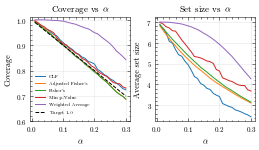

In [2]:
plt.style.use(['science', 'no-latex'])
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 5,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.5,
})

def plot_alpha_sweep(P_dict: Dict[str, np.ndarray], y_true: np.ndarray, alphas: np.ndarray, outpath: str):
    methods_order = ["CLF","Adjusted Fisher's","Fisher's","Min p-Value","Weighted Average"]
    colors = sns.color_palette("tab10", n_colors=len(methods_order))
    fig, axs = plt.subplots(1, 2, figsize=(3.54, 2), constrained_layout=True)

    ax = axs[0]
    for idx, m in enumerate(methods_order):
        cov, _ = compute_curves_over_alpha(P_dict[m], y_true, alphas)
        ax.plot(alphas, cov, label=m, color=colors[idx])
    ax.plot(alphas, 1 - alphas, linestyle='--', color='k', label=r'Target 1-$\alpha$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Coverage')
    ax.set_title('Coverage vs $\\,\\alpha$')
    ax.set_ylim(0.6, 1.01)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', ncol=1, frameon=False)

    ax = axs[1]
    for idx, m in enumerate(methods_order):
        _, size = compute_curves_over_alpha(P_dict[m], y_true, alphas)
        ax.plot(alphas, size, label=m, color=colors[idx])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Average set size')
    ax.set_title('Set size vs $\\,\\alpha$')
    ax.grid(True, alpha=0.3)

    plt.savefig(outpath, bbox_inches='tight', dpi=600)
    print(f"Saved figure to {outpath}")
    plt.show()
    
alphas = np.linspace(0.01, 0.30, 30)
plot_alpha_sweep(P_dict, y_te, alphas, outpath="./meld_alpha_sweep_v2.pdf")